# Generate sample with noise

In [1]:
from __future__ import print_function

import numpy as np
import reflexxes
import random
#import pandas as pd
from numpy import genfromtxt

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from hmmlearn import hmm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
# plot the data
def on_key_press(event):
    if event.key == 'escape':
        plt.close()

In [3]:
def original_plot(x, dd, dddx):
    t = np.linspace(0, len(x) * gen.cycle_time, len(x))
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    ax1.plot(t, x)
    ax1.set_ylabel('position')
    ax1.legend('123', title='DOF #')
    ax2.plot(t, dx)
    ax2.set_ylabel('velocity')
    ax2.legend('123', title='DOF #')
    ax3.plot(t, ddx)
    ax3.set_ylabel('acceleration')
    ax3.legend('123', title='DOF #')
    ax3.set_xlabel('time')
    plt.show()

In [4]:
def plot_trajectory(x, title):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')

In [5]:
# used to generate velocity, position and acceleration
def generate_random_variable(lower_limit, higher_limit):
    return [random.randrange(lower_limit, higher_limit), 
            random.randrange(lower_limit, higher_limit), 
            random.randrange(lower_limit, higher_limit)]

In [6]:
'''
Randomized elements: starting & ending poisition, velocity and acceleration 

'''

def generate_trajectory(gen):
    # set initial values
    gen.current_position = generate_random_variable(0, 100)
    gen.current_velocity = generate_random_variable(-10, 10)
    gen.current_acceleration = generate_random_variable(0, 5)

    position = [gen.current_position.tolist()]
    velocity = [gen.current_velocity.tolist()]
    acceleration = [gen.current_acceleration.tolist()]
    
    # generate trajectory
    for pos, vel, acc in gen.trajectory(generate_random_variable(0, 100), generate_random_variable(-10, 10), 1):
        '''
        auto trajectory(const RMLDoubleVector& target_position,
                    const RMLDoubleVector& target_velocity,
                    double min_sync_time = 0.0)
                    '''
        position.append(pos)
        velocity.append(vel)
        acceleration.append(acc)
        
    return position, velocity, acceleration

In [7]:
def generate_trajectory_recur(gen, count=0, position=None, velocity=None, acceleration=None):
    # set initial values
    gen.current_position = position[-1] if position else generate_random_variable(0, 100)
    gen.current_velocity = velocity[-1] if velocity else generate_random_variable(-10, 10)
    gen.current_acceleration = acceleration[-1] if acceleration else generate_random_variable(0, 5)

    position = position or [gen.current_position.tolist()]
    velocity = velocity or [gen.current_velocity.tolist()]
    acceleration = acceleration or [gen.current_acceleration.tolist()]

    target_position = generate_random_variable(0, 100)
    target_velocity = generate_random_variable(-10, 10)
    
    # generate trajectory
    for pos, vel, acc in gen.trajectory(target_position, target_velocity, 1):
        '''
        auto trajectory(const RMLDoubleVector& target_position,
                    const RMLDoubleVector& target_velocity,
                    double min_sync_time = 0.0)
                    '''
        position.append(pos)
        velocity.append(vel)
        acceleration.append(acc)
        
    if count == 0:
        return position, velocity, acceleration
    else:
        return generate_trajectory_recur(gen, count - 1, position, velocity, acceleration)

In [8]:
'''
explicit PositionTrajectoryGenerator(unsigned number_of_dofs,
                                    double cycle_time,
                                    const RMLDoubleVector& max_velocity,
                                    const RMLDoubleVector& max_acceleration,
                                    const RMLDoubleVector& max_jerk)
'''
gen = reflexxes.extra.PositionTrajectoryGenerator(
    number_of_dofs=3,
    cycle_time=0.01,
    max_velocity=[10, 10, 10],
    max_acceleration=[8, 8, 8],
    max_jerk=[4, 5, 6]
)

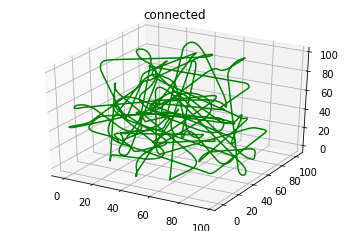

In [10]:
p, v, a = generate_trajectory_recur(gen, 64)
plot_trajectory(p, "connected")

In [11]:
data_size = 100

In [14]:
def save_to_csv(data, file_name):
    pos_list = []
    for pos in data:
        pos_list.append(pos)
    np.savetxt('data0503/' + file_name + '.csv', np.array(pos_list))

## Generate original data without noise

### Random trejectories / individual trajectories has no interdependency

In [27]:
random.seed(7777)

In [28]:
original_data = [] # store all original data without noise
original_positions = []
original_velocities = []
# first layer: number of samples/trajectories
# second layer: position, velocity, accelaration, each a list of 3 dimensional list

In [29]:
for i in range(data_size):
    pos, vel, acc = generate_trajectory(gen)
    #original_data.append([pos, vel, acc])
    # plot_trajectory(pos, 'Trajectory for ' + str(i))
    original_positions.append(pos)
    original_velocities.append(vel)

In [30]:
# get the length and dataset of each traj
traj_lens = []

original_position_list = []
for pos in original_positions:
    original_position_list.extend(pos)
    traj_lens.append(len(pos))

original_velocity_list = []
for vel in original_velocities:
    original_velocity_list.extend(vel)

In [31]:
len(original_position_list)

65900

In [32]:
np.savetxt("data0503/original_position_list.csv", np.array(original_position_list))
np.savetxt("data0503/original_velocity_list.csv", np.array(original_velocity_list))
np.savetxt("data0503/traj_lens.csv", np.array(traj_lens))

### Previous trajectory's end position being next trajectory's starting point

In [33]:
random.seed(7777)
continuous_data = []
continuous_positions = []

### separate trajectories with different noises

In [34]:
def add_noise_to_original_data(original_data, error_range, plot):
    processed_data = []

    # generate random noise with size same as number of points of positions
    noise = np.random.uniform(-error_range, error_range, (original_data.shape[0], original_data.shape[1]))
    # np.random.normal(mean, sigma, (original_data.shape[0], original_data.shape[1]))
    noisy_traj = original_data + noise
    processed_data.extend(noisy_traj)

    if plot:
        plot_trajectory(original_data, 'Before noise')
        plot_trajectory(processed_data, 'After noise')
    
    return processed_data

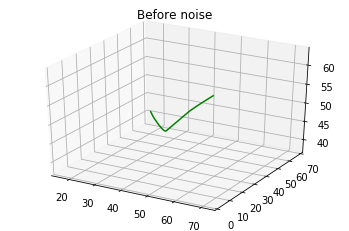

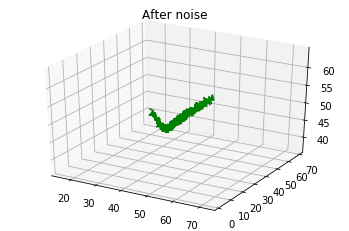

In [35]:
# add noise to positions
test1 = add_noise_to_original_data(np.array(original_positions[0]), 1, True)

In [36]:
def add_noise_for_all_trej(noise_range): 
    sample_trajectories = []
    # add noise for positions
    for trajectory in original_positions:
        sample_trajectories.extend(add_noise_to_original_data(np.array(trajectory), noise_range, False))
        # use append if want to separate each trajectory
    return sample_trajectories

In [37]:
# add noise with uniform distribution
noise_ranges = [0.1, 1, 2, 5 ]
for noise_range in noise_ranges:
    position_noise = add_noise_for_all_trej(noise_range)
    save_to_csv(position_noise, 'position_noise_' + str(noise_range))

## Learn HMM from sample

In [ ]:
# generate length of each sample
trajectory_length = []
for trajectory in original_positions:
    trajectory_length.append(len(trajectory))

In [ ]:
HMM = hmm.GaussianHMM(n_components=10, covariance_type="full", n_iter=data_size, verbose=True)

In [ ]:
# TODO: use a proper way
trajectories = original_positions[len(original_positions) - 1]
for i in range(len(original_positions) - 1):
#for sample in sample_trajectories:
    trajectories = np.concatenate((trajectories, original_positions[i]))

In [ ]:
trajectories

In [ ]:
lengths = np.array(trajectory_length)

In [ ]:
trajectories.shape

In [ ]:
HMM.fit(trajectories, lengths)

In [ ]:
HMM.means_

In [ ]:
plot_trajectory(HMM.means_, 'Means')

In [ ]:
pred = HMM.predict(sample_trajectories[0])

In [ ]:
trej = []
for point in pred:
    trej.append(HMM.means_[point])

In [ ]:
plot_trajectory(trej, 'Trej')

In [ ]:
plot_trajectory(sample_trajectories[0], 'Real')